<span style="font-size: 1.5em">Анализ поведения пользователей мобильной игры</span>

Я аналитик, анализирующий поведение пользователей игры "Космические братья". В ней пользователи строят свою космическую программу и пытаются преуспеть в нелёгком деле колонизации галактики. Основная монетизация игры — только планируется. Но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки. \
В датасете представлены данные по игре пользователей на первом уровне.
Завершение первого уровня требует от игрока выполнения одного из двух
условий:
 - Победа над первым врагом
 - Реализация проекта - разработка орбитальной сборки спутников


Задачи: 
- проведение исследовательского анализа данных;
- анализ влияния источника перехода в игру на поведение пользователя;
- проверка статистических гипотез о продолжительности прохождения первого уровня и числе построенных зданий для игроков, выбравших разные стратегии игры: "победа над врагом" и "реализация проекта"

В основном датасете game_actions.csv содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно.

Датасет game_actions.csv:
- event_datetime — время события;
- event — одно из трёх событий:
1. building — объект построен,
2. finished_stage_1 — первый уровень завершён,
3. project — проект завершён;
- building_type — один из трёх типов здания:
1. assembly_shop — сборочный цех,
2. spaceport — космопорт,
3. research_center — исследовательский центр;
- user_id — идентификатор пользователя;
- project_type — тип реализованного проекта;

Помимо основного датасета есть два датасета с информацией о рекламных активностях. Они также помогут в решении задачи.
Датасет ad_costs.csv:
- day - день, в который был совершен клик по объявлению
- source - источник трафика
- cost - стоимость кликов

Датасет user_source.csv содержит колонки:
- user_id - идентификатор пользователя
- source - источников, с которого пришёл пользователь, установивший приложение

<span style="font-size: 1.5em">Часть 1. Загрузка данных и изучение общей информации</span>

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import matplotlib.ticker as ticker
%matplotlib inline
import numpy as np

In [2]:
#загрузим датафрейм с информацией о действиях пользователей в играх
games = pd.read_csv('.../.../game_actions.csv')
games.head()

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


In [3]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


Все поля в датафрейме имеют тип object. В поле building_type отсутствует незначительное количество данных. В поле project_type подавляющее большинство значений отстутствует. Всего в датафрейме более 135 тыс. действий, совершенных пользователями.

In [4]:
games['event'].unique()

array(['building', 'finished_stage_1', 'project'], dtype=object)

В поле event всего три уникальных значения: построенное здание, окончание 1 стадии и реализация проекта.

In [5]:
games['building_type'].unique()

array(['assembly_shop', 'spaceport', nan, 'research_center'], dtype=object)

Существует 3 различных вида зданий, которые строят игроки. Однако подробной информации о том, что они дают игрокам, у нас в доступе нет.

In [6]:
games['project_type'].unique()

array([nan, 'satellite_orbital_assembly'], dtype=object)

В датасете присутствует только один тип проекта - строительство орбитальной станции.

In [7]:
games['event_datetime'].min()

'2020-05-04 00:00:01'

In [8]:
games['event_datetime'].max()

'2020-06-05 12:32:49'

Временной горизонт датафрейма с 4 мая по 5 июня 2020 года.

In [9]:
#загрузим датафрейм с рекламными расходами по дням
costs = pd.read_csv('.../.../ad_costs.csv')
costs.head()

,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


In [10]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


В датафрейме 28 наблюдений. Поле с информацием о дне осуществления расходов имеент тип object. Во всех полях отстутсвующих значений нет.

In [11]:
costs['source'].unique()

array(['facebook_ads', 'instagram_new_adverts', 'yandex_direct',
       'youtube_channel_reklama'], dtype=object)

В датафрейме представлены 4 источника привлечения пользователей.

In [12]:
costs['day'].min()

'2020-05-03'

In [13]:
costs['day'].max()

'2020-05-09'

Временной горизонт датафрейма с 3 по 9 мая.

In [14]:
#загрузим датафрейм с информацией об источниках привлечения пользователей в игру
user_source = pd.read_csv('.../.../user_source.csv')
user_source.head()

,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


In [15]:
user_source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


В датафрейме присутствует более 13 тыс. пользователей. Отсутствующих значений нет.

**Выводы**: все датафреймы загружены.

<span style="font-size: 1.5em">Часть 2. Предобработка данных</span>

Преобразуем типы данных в датафреймах там, где это нужно.

In [16]:
games['event_datetime'] = pd.to_datetime(games['event_datetime'])
games['event_datetime'].dtype

dtype('<M8[ns]')

In [17]:
costs['day'] = pd.to_datetime(costs['day'])
costs['day'].dtype

dtype('<M8[ns]')

Изучим наличие пропусков. Еще раз посмотрии пропуски по полям.

In [18]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_datetime  135640 non-null  datetime64[ns]
 1   event           135640 non-null  object        
 2   building_type   127957 non-null  object        
 3   user_id         135640 non-null  object        
 4   project_type    1866 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 5.2+ MB


В поле building_type пропуски обоснованы тем, что не все действия пользователей связаны со зданиями. Пропуски отражают как раз такие действия. Тоже самое относится и к полю project_type. Большинство действий пользователей не связаны с проектами. Поэтому оставим пропуски как есть, их ничем не заменишь. В остальных датафреймах, как мы видели раньше, пропусков нет.

Проверим датафреймы на наличие дубликатов.

In [19]:
games[games.duplicated()]

,event_datetime,event,building_type,user_id,project_type
74891,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN


Обнаружен 1 дубликат. Удалим его.

In [20]:
games = games.drop_duplicates()

In [21]:
costs[costs.duplicated()]

,source,day,cost


In [22]:
user_source[user_source.duplicated()]

,user_id,source


В остальных датафреймах дубликаты не обнаружены. Неявных дубликатов быть не должно с учетом того, как данные в таблицах сформированы.

Создадим новый датафрейм с профилями пользователей. 

In [23]:
#добавим первые 2 столбца в новый датафрейм, просто скопируем датафрейм с источниками
profiles = user_source

In [24]:
#найдем день, когда пользователи в первый раз зашли в игру
user_first_day = games.groupby(['user_id'], as_index=False)['event_datetime'].min()

In [25]:
#соединим датафреймы и изменим название столбца
profiles = profiles.merge(user_first_day, on='user_id')
profiles = profiles.rename(columns={'event_datetime': 'first_action'})

In [26]:
#найдем день, когда пользователи в последний раз зашли в игру
user_last_day = games.groupby(['user_id'], as_index=False)['event_datetime'].max()

In [27]:
#соединим датафреймы и изменим название столбца
profiles = profiles.merge(user_last_day, on='user_id')
profiles = profiles.rename(columns={'event_datetime': 'last_action'})

In [28]:
#создадим столбец со временем между первым и последним посещением игры
profiles['time_difference'] = profiles['last_action'] - profiles['first_action']

In [29]:
#создадим список пользователей, завершили первый уровень
users_finished = games[games['event'] == 'finished_stage_1']['user_id'].values

In [30]:
#создадим цикл, если пользователь в профилях закончил первый уровень, то возвращается True, иначе False
#добавим все эти значения в новый список
list_finished = []
for index, user in enumerate(profiles['user_id']):
    if user in users_finished:
        list_finished.append(True)
    else:
        list_finished.append(False)

In [31]:
#вставим этот булевый список в качестве нового столбца, в котором будет информация, прошел ли пользователь первый уровень
profiles['finished_1_stage'] = list_finished

Дальше нам в профилях нужно указать, какую стратегию выбрал пользователь: победить врага или построить станцию. Датафрейм с действиями пользователей сформирован таким образом, что не сразу очевидно, какую стратегию он выбрал. Если в датафрейме указано, что пользователь прошел 1 уровень, но при этом не реализовал проект по строительству станции, значит, он выбрал стратегию победы над врагом. Следующая задача - создать столбец, в котором будет информация о том, каким образом пользователь смог пройти 1 уровень. У столбца будет всего 3 значения: "не прошел 1 уровень", "победил врага", "реализовал проект".

In [32]:
#определим список пользователей, которые реализовали проект
users_project = games[games['event'] == 'project']['user_id'].values

In [33]:
#создадим цикл, который будет возврщать информацию о том, каким образом пользователи закончили первый уровень
#добавим все эти значения в новый список
list_strategy = []
for index, user in enumerate(profiles['user_id']):
    if user in users_finished and user not in users_project:
        list_strategy.append('победил врага')
    elif user in users_finished and user in users_project:
        list_strategy.append('реализовал проект')
    elif user not in users_finished:
        list_strategy.append('не прошел 1 уровень')

In [34]:
#создадим столбец со стратегией, которую выбрал пользователь для прохождения 1 уровня
profiles['strategy'] = list_strategy

Далее создадим столбец с информацией о том, сколько зданий построил пользователь. Сначала создадим датафрейм, где бы отражалось, сколько каждый пользователь построил зданий.

In [35]:
count_building = games[games['event'] == 'building'].groupby('user_id', as_index=False)['event'].count().rename(columns={
    'event': 'count_building'})

In [36]:
#добавим в профили информацию о количестве построенных зданий
profiles = profiles.merge(count_building, on='user_id', how='left')

Далее нам нужно посчитать, сколько стоит привлечение каждого нового пользователя. Для начала посчитаем общее количество новых пользователей по дням и по источникам привлечения.

In [37]:
#создадим новый столбец с первым днем, когда он начал играть
profiles['first_day'] = profiles['first_action'].dt.date

In [38]:
count_users = profiles.groupby(['first_day', 'source'], as_index=False)['user_id'].count().rename(columns={'user_id':'users'})
count_users['first_day'] = pd.to_datetime(count_users['first_day'])

Нужно учесть, что данные по расходам на рекламу немного смещены. Реклама, которая была оплачена 4 мая, была показана потенциальным пользователем 5 мая. Поэтому создадим в таблице costs новый столбец, который бы отразил день, когда данная реклама действительно была показана пользователям. Назовем столбец first_day

In [39]:
costs['first_day'] = costs['day'] + pd.DateOffset(days=1)

In [40]:
#добавим в таблицу с информацией о числе пользователей данные о совокупной стоимости их привлечения
count_users = count_users.merge(costs[['source', 'cost', 'first_day']], on=['source', 'first_day'])

In [41]:
#создадим столбец с информацией о средствах, которые были потрачены на 1 пользователя
count_users['cost_per_user'] = count_users['cost'] / count_users['users']
count_users

,first_day,source,users,cost,cost_per_user
0,2020-05-04,facebook_ads,1184,935.882786,0.790442
1,2020-05-04,instagram_new_adverts,1452,943.204717,0.649590
2,2020-05-04,yandex_direct,2078,969.139394,0.466381
3,2020-05-04,youtube_channel_reklama,1146,454.224943,0.396357
4,2020-05-05,facebook_ads,694,548.354480,0.790136
5,2020-05-05,instagram_new_adverts,796,502.925451,0.631816
6,2020-05-05,yandex_direct,1208,554.651494,0.459149
7,2020-05-05,youtube_channel_reklama,663,259.073224,0.390759
8,2020-05-06,facebook_ads,345,260.185754,0.754162
9,2020-05-06,instagram_new_adverts,472,313.970984,0.665193


In [42]:
profiles['first_day'] = pd.to_datetime(profiles['first_day'])

In [43]:
#добавим в профили информацию о стоимости привлечения пользователя
profiles = profiles.merge(count_users[['first_day', 'source', 'cost_per_user']], on=['first_day', 'source'], how='left')

Создадим метрику того, насколько рентабельно привлечение конкретного пользователя. Игра генерирует прибыль с каждого построенного здания пользователем. В тот момент, когда здание строится, пользователю показывается реклама. Таким образом, померить, насколько окупается привлечение конкретного пользователя можно разделив стоимость его привлечения на число построек. Полученный результат - ориентир, сколько должна приносить реклама с одной постройки, чтобы данный конкретный пользователь окупился. Данную метрику можно сравнивать между различными пользователями. Фактически - чем ниже это значение, тем лучше для владельцев игры. Назовем столбец 'payback' - оккупаемость. 

In [44]:
profiles['payback'] = profiles['cost_per_user'] / profiles['count_building']
profiles.head()

,user_id,source,first_action,last_action,time_difference,finished_1_stage,strategy,count_building,first_day,cost_per_user,payback
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads,2020-05-06 01:07:37,2020-05-20 11:26:06,14 days 10:18:29,False,не прошел 1 уровень,13,2020-05-06,0.754162,0.058012
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct,2020-05-06 03:09:12,2020-05-18 10:46:52,12 days 07:37:40,False,не прошел 1 уровень,9,2020-05-06,0.464206,0.051578
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama,2020-05-05 18:08:52,2020-05-14 09:21:27,8 days 15:12:35,False,не прошел 1 уровень,4,2020-05-05,0.390759,0.097690
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts,2020-05-05 21:02:05,2020-05-12 07:40:47,6 days 10:38:42,True,победил врага,8,2020-05-05,0.631816,0.078977
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads,2020-05-05 13:49:58,2020-05-22 02:46:45,16 days 12:56:47,False,не прошел 1 уровень,12,2020-05-05,0.790136,0.065845


**Вывод:** данные подготовлены к последующему анализу данных. Был создан новый основной датафрейм с профилями пользователей, где указана важная для анализа информация: источник привлечения, даты первого и последнего посещения игры, игровая стратегия пользователя, количество построенных зданий, стоимость его привлечения и метрика, которая показывает порог окупаемости пользователя.

<span style="font-size: 1.5em">Часть 3. Исследовательский анализ данных</span>

Сначала посмотрим динамику появления новых пользователей по дням.

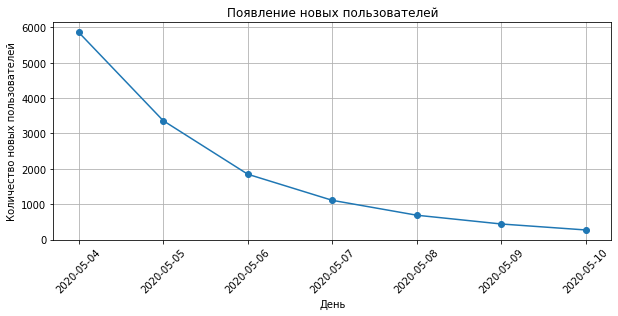

In [48]:
new_users = profiles.groupby('first_day', as_index=False)['user_id'].count()
plt.figure(figsize=(10, 4))
plt.plot(new_users['first_day'], new_users['user_id'], marker='o')
plt.xlabel('День')
plt.ylabel('Количество новых пользователей')
plt.title('Появление новых пользователей')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Как видно из графика, с каждым днем в игру привлекалось мне меньше пользователей. Возможно, это связано с тем, что уменьшлся совокупный объем средств, выделяемых на рекламу. Посмотрим, как менялся этот показатель.

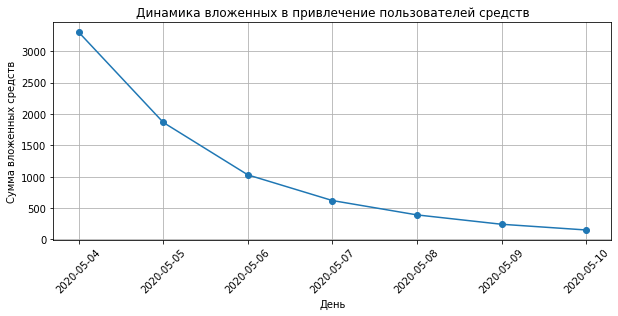

In [49]:
costs_per_day = costs.groupby('first_day', as_index=False)['cost'].sum()
plt.figure(figsize=(10, 4))
plt.plot(costs_per_day['first_day'], costs_per_day['cost'], marker='o')
plt.xlabel('День')
plt.ylabel('Сумма вложенных средств')
plt.title('Динамика вложенных в привлечение пользователей средств')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Как мы видим, графики практически аналогичные. Падения числа новых пользователей связано не с уменьшением отдачи от рекламы, а с тем, что банально изо дня в день сумма вложенных в рекламу средств уменьшалась в течение недели.

Рассмотрим другие ключевые параметры: сколько в целом пользователи строят зданий. Это важно понять, что бы определить минимальный порог стоимости показываемой пользователям рекламы, который нужен, чтобы привлечение пользователей в среднем окупалось.

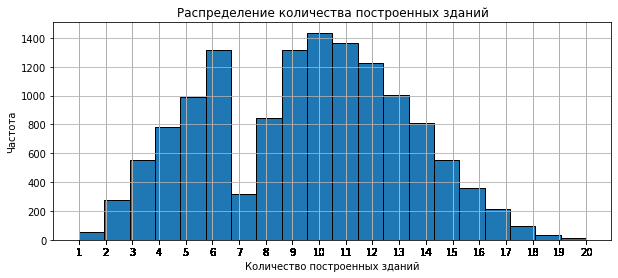

In [50]:
plt.figure(figsize=(10, 4))
plt.hist(profiles['count_building'], bins=20, edgecolor='black')
plt.xlabel('Количество построенных зданий')
plt.ylabel('Частота')
plt.title('Распределение количества построенных зданий')
plt.grid(True)
plt.gca().xaxis.set_major_locator(ticker.FixedLocator(profiles['count_building'].astype(int)))
plt.gca().xaxis.set_major_formatter(ticker.FixedFormatter(profiles['count_building'].astype(int)))
plt.show()

Как можно видеть из гистрограммы, распределение имеет две вершины. Часть большое количество пользователей строит 6 зданий, а вот тех, которые бы построили 7 или 8 значительно меньше. Потом опять начинается рост, и значительное число пользователей построило от 9 до 11 зданий. Возможно, первая вершина - это те пользователи, которые не смогли пройти 1 уровень и бросили игру. Более внимательно посмотрим на то, как распределено число пользователей, которые прошли 1 уровень.

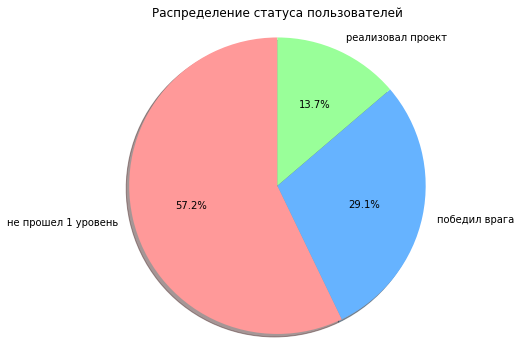

In [51]:
strategy = profiles['strategy'].value_counts()

# Построение круговой диаграммы
plt.figure(figsize=(8, 6))
colors = ['#ff9999', '#66b3ff', '#99ff99']
plt.pie(strategy, labels=strategy.index, autopct='%1.1f%%', startangle=90,
        colors=colors, shadow=True)
plt.axis('equal')  # Устанавливаем равные пропорции по осям x и y
plt.title('Распределение статуса пользователей')

plt.show()

Большинство пользователей не прошли первый уровень. Около трети - те, кто победил врага, и только 13% - реализовали проект. Посмотрим как распределено число построенных зданий между этими тремя группами с помощью боксплота. Из этого распределения не до конца очевидно, те пользователи, которые не прошли уровень, просто не успели еще это делать или они забросили игру. Попробуем более подробно изучить этот момент. 

In [52]:
not_finished_users = profiles[profiles['finished_1_stage'] == False]

Нарисуем гистограму, которая будет показывать, в какой день чаще всего пользователи играли чаще всего. Те пользователи, которые играли совсем недавно, скорее всего просто не успели пройти 1 уровень и вполне могут пройти его через некоторое время.

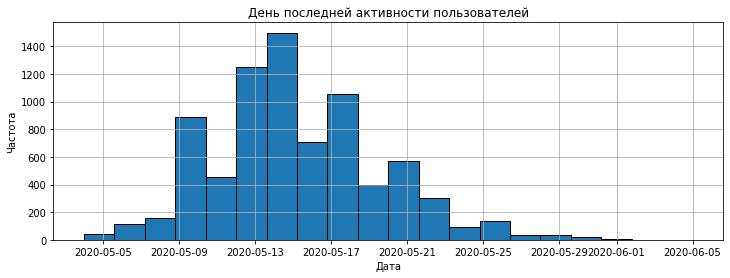

In [53]:
plt.figure(figsize=(12, 4))
plt.hist(not_finished_users['last_action'].dt.date, bins=20, edgecolor='black')
plt.xlabel('Дата')
plt.ylabel('Частота')
plt.title('День последней активности пользователей')
plt.grid(True)
plt.show()

Выводы гистограммы не самые утешительные: подавляющее число пользователей играло в последний раз за 2 недели до самой последней доступной даты в датасете. Это значит, что скорее всего они забросили игру и не будут в нее играть дальше. Пользователей, которые играли в нее недавно, настолько мало, что можно сделать допущение и считать всех пользователей, которые не прошли 1 уровень, бросившими игру, для целей дальнейшего исследования. 	

Посмотрим, как распределено среднее количество построенных зданий среди различных групп пользователей.

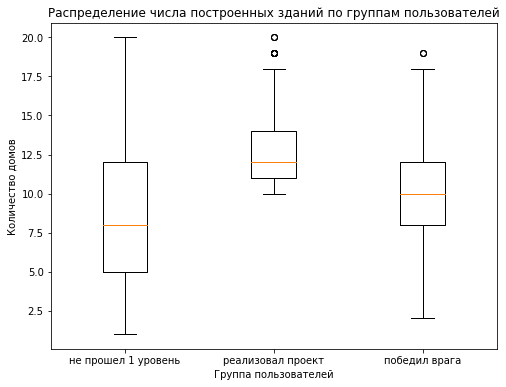

In [54]:
groups = ['не прошел 1 уровень', 'реализовал проект', 'победил врага']
data = [profiles[profiles['strategy'] == group]['count_building'] for group in groups]
plt.figure(figsize=(8, 6))
plt.boxplot(data, labels=groups)
# Добавление подписей осей и заголовка
plt.xlabel('Группа пользователей')
plt.ylabel('Количество домов')
plt.title('Распределение числа построенных зданий по группам пользователей')
plt.show()

- Как видно в среднем количество построенных зданий тех, кто не прошел 1 уровень значительно меньше, чем тех, кто прошел, что было очевидно. Интересно, что часть пользователей, которые не прошли 1 уровень, все же построили достаточно много зданий, так как верхний ус боксплота достаточно высоко находится. 
- Также интересна разница между 2 выбранными стратегиями, которая уже начинает вырисовываться: чтобы реализовать проект нужно построить минимум 10 зданий, а чтобы победить врага можно всего и 3 построенными зданиями.

Далее узнаем, сколько в среднем требуется игрокам, чтобы пройти первый уровень.

In [55]:
#Выделим сначала тех пользователей, которые прошли 1 уровень
finished_users = profiles[profiles['finished_1_stage'] == True]

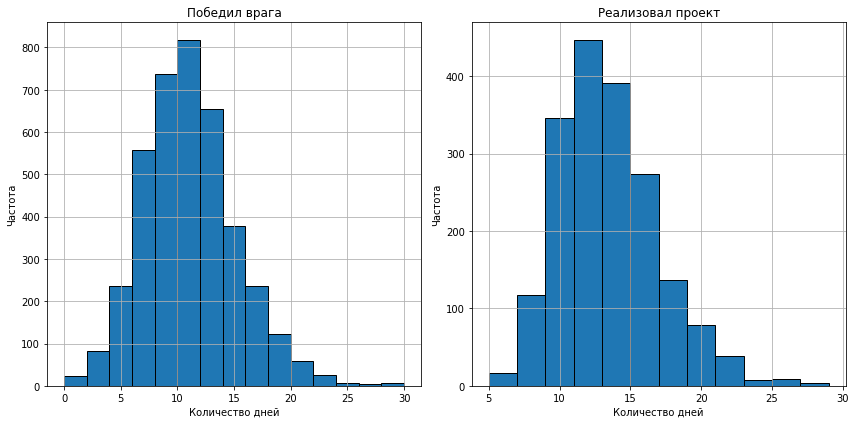

In [56]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Построение первой гистограммы
axs[0].hist(finished_users[finished_users['strategy'] == 'победил врага']['time_difference'].dt.days, bins=15, edgecolor='black')
axs[0].set_xlabel('Количество дней')
axs[0].set_ylabel('Частота')
axs[0].set_title('Победил врага')
axs[0].grid(True)

# Построение второй гистограммы
axs[1].hist(finished_users[finished_users['strategy'] == 'реализовал проект']['time_difference'].dt.days, bins=12, edgecolor='black')
axs[1].set_xlabel('Количество дней')
axs[1].set_ylabel('Частота')
axs[1].set_title('Реализовал проект')
axs[1].grid(True)

# Автоматическое размещение графиков и отображение
plt.tight_layout()
plt.show()

Несмотря на то, что в двух стратегиях мода распределения находится где-то на 12 днях игры. В случае со стратегией "победа врага" распределение смещено немного влево, и достаточно много игроков прошло первый уровень в период от 5 до 10 дней, в то время как "реализация проекта" для подавляющего числа пользователей занимает более 10 дней. Более детально данный пункт рассмотрим в части проекта с проверкой гипотез.

**Выводы:** в датасете представлены пользователи, которые привлекались в течение недели, при это на первые дни привлечения приходится большая часть пользователей. Из все привлеченных пользователей почти 60% не прошли первый уровень, поиграл в игру всего пару недель. Из тех, кто прошел первый уровень, большинство выбрало стратегию "победа над врагом". И эта стратегия, на первый взгляд, в среднем требует от пользователя меньше потраченного времени и построенных зданий.

<span style="font-size: 1.5em">Часть 4. Анализ влияния источника перехода в игру на привлечение пользователей.</span>

Посмотрим динамику привлечения пользователей в зависимости от источников привлечения.

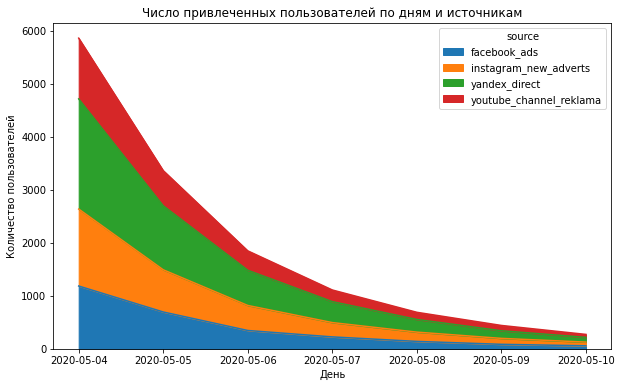

In [58]:
profiles['first_day'] = pd.to_datetime(profiles['first_day'])
profiles['first_day'] = profiles['first_day'].dt.date
# Группировка данных по 'день' и 'источник'
grouped_data = profiles.groupby(['first_day', 'source']).size().unstack()

# Визуализация
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
grouped_data.plot.area(stacked=True, ax=ax)

# Настройка осей и заголовка
plt.xlabel('День')
plt.ylabel('Количество пользователей')
plt.title('Число привлеченных пользователей по дням и источникам')

# Отображение графика
plt.show()

Изначально больше всего пользователей привлекали через Яндекс, меньше всего - через Ютуб. Данная пропорция между каналами примерно сохраняется притом, что доля привлекаемых пользователей изо дня в день падала. Посмотрим, как изменялся объем средств, потраченных на различные источники. 

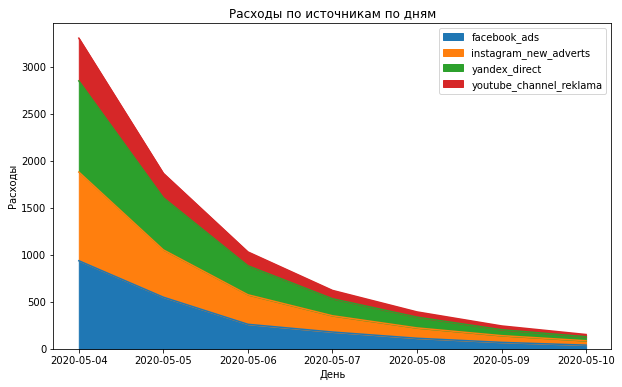

In [59]:
# Преобразование столбца 'first_day' в формат даты
costs['first_day'] = pd.to_datetime(costs['first_day'])
costs['first_day'] = costs['first_day'].dt.date
fig = plt.figure(figsize=(10, 6))

# Построение area chart с параметром stacked=True
ax = fig.add_subplot(111)
costs.pivot(index='first_day', columns='source', values='cost').plot.area(stacked=True, ax=ax)

# Настройка осей и заголовка
plt.xlabel('День')
plt.ylabel('Расходы')
plt.title('Расходы по источникам по дням')
plt.legend()

# Отображение графика
plt.show()

Потраченные средства снижались каждый день по всем каналам, однако на данном графике не видно явного доминирования Яндекса, как на прошлом графике. В Яндекс, Инстаграм и Фейсбук было вложено примерно одинаковое количество средств (даже в последний немного больше, чем в другие), однако число привлеченных пользователей от яндекса было больше. Сравним средний объем потраченных средств на одного привлеченного человека по различным источникам через боксплот.

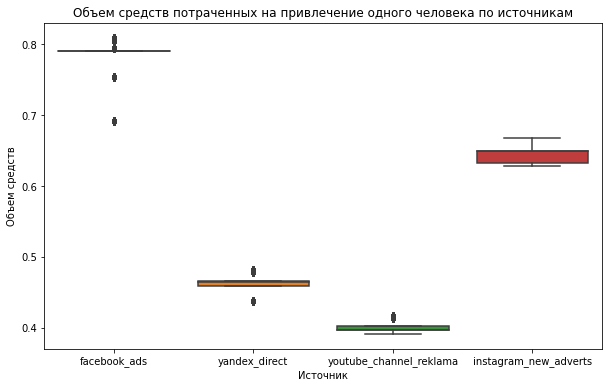

In [60]:
# Настройка размера графика
plt.figure(figsize=(10, 6))
# Разделение расходов на источники
sns.boxplot(x='source', y='cost_per_user', data=profiles)

# Настройка осей и заголовка
plt.xlabel('Источник')
plt.ylabel('Объем средств')
plt.title('Объем средств потраченных на привлечение одного человека по источникам')

# Отображение графика
plt.show()

Как и оказалось, стоимость привлечения через фейсбук - самая дорогая. Инстаграм также достаточно дорогой. А вот яндекс и ютуб - достаточно дешевые источники. Возможно, рекламу через Ютуб стоит увеличить, сейчас по объему потраченных средств данная плафторма находится на последнем месте. Таким же образом посмотрим, сколько зданий в среднем строят пользователи различных плафторм, и какова средняя окупаемость пользователя.

In [61]:
profiles

,user_id,source,first_action,last_action,time_difference,finished_1_stage,strategy,count_building,first_day,cost_per_user,payback
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads,2020-05-06 01:07:37,2020-05-20 11:26:06,14 days 10:18:29,False,не прошел 1 уровень,13,2020-05-06,0.754162,0.058012
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct,2020-05-06 03:09:12,2020-05-18 10:46:52,12 days 07:37:40,False,не прошел 1 уровень,9,2020-05-06,0.464206,0.051578
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama,2020-05-05 18:08:52,2020-05-14 09:21:27,8 days 15:12:35,False,не прошел 1 уровень,4,2020-05-05,0.390759,0.097690
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts,2020-05-05 21:02:05,2020-05-12 07:40:47,6 days 10:38:42,True,победил врага,8,2020-05-05,0.631816,0.078977
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads,2020-05-05 13:49:58,2020-05-22 02:46:45,16 days 12:56:47,False,не прошел 1 уровень,12,2020-05-05,0.790136,0.065845
...,...,...,...,...,...,...,...,...,...,...,...
13571,ffef4fed-164c-40e1-bde1-3980f76d0fb5,instagram_new_adverts,2020-05-04 01:58:59,2020-05-11 22:15:54,7 days 20:16:55,True,победил врага,9,2020-05-04,0.649590,0.072177
13572,fffab3da-da0e-4e30-ae62-10d0a2e24a4e,facebook_ads,2020-05-04 11:58:14,2020-05-14 10:11:36,9 days 22:13:22,False,не прошел 1 уровень,16,2020-05-04,0.790442,0.049403
13573,fffb626c-5ab6-47c9-8113-2062a2f18494,yandex_direct,2020-05-04 02:05:09,2020-05-12 13:01:52,8 days 10:56:43,True,победил врага,9,2020-05-04,0.466381,0.051820
13574,ffff194a-56b7-4c12-860d-3485242ae7f5,instagram_new_adverts,2020-05-04 20:28:28,2020-05-11 22:04:30,7 days 01:36:02,False,не прошел 1 уровень,7,2020-05-04,0.649590,0.092799


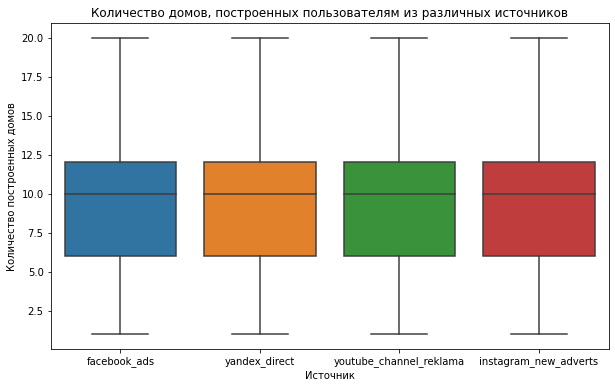

In [62]:
# Настройка размера графика
plt.figure(figsize=(10, 6))
# Разделение количества построенных домов на источники
sns.boxplot(x='source', y='count_building', data=profiles)

# Настройка осей и заголовка
plt.xlabel('Источник')
plt.ylabel('Количество построенных домов')
plt.title('Количество домов, построенных пользователям из различных источников')

# Отображение графика
plt.show()

Как видно из графика, пользователи из различных каналов строят практически идентичное количество зданий с одинаковым разбросом. Таким образом, разница в окупаемости пользователей происходит только в результате разницы стоимости привлечения пользователей. Посмотрим это на графике.

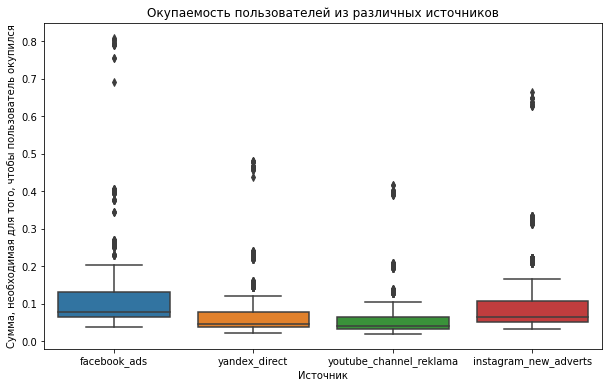

In [63]:
# Настройка размера графика
plt.figure(figsize=(10, 6))
# Разделение окупаемости пользователей на источники
sns.boxplot(x='source', y='payback', data=profiles)

# Настройка осей и заголовка
plt.xlabel('Источник')
plt.ylabel('Сумма, необходимая для того, чтобы пользователь окупился')
plt.title('Окупаемость пользователей из различных источников')

# Отображение графика
plt.show()

Ряд пользователей почти ничего не строили, при этом на их привлечение тратился тот же объем средств, от этого видны выбросы. Ограничим рисунок сверху.

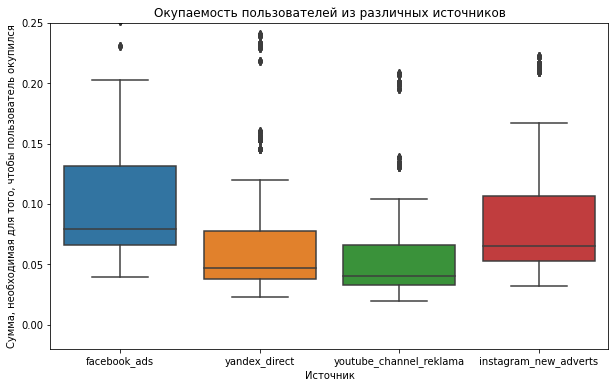

In [64]:
# Настройка размера графика
plt.figure(figsize=(10, 6))
# Разделение окупаемости пользователей на источники
ax = sns.boxplot(x='source', y='payback', data=profiles)
ax.set_ylim(top=0.25)
# Настройка осей и заголовка
plt.xlabel('Источник')
plt.ylabel('Сумма, необходимая для того, чтобы пользователь окупился')
plt.title('Окупаемость пользователей из различных источников')

# Отображение графика
plt.show()

Чтобы окупились пользователи с Ютуба и Яндекса потребуется значительно меньше средств от показа рекламы, чем в случае с пользователями из инстаграма и фейсбука.

Рассмотрим еще один момент. Вдруг пользователи, привлеченные через один канал более стабильные игроки, чем через другие. Если такая зависимость реально есть, то вполне вероятно, что такие пользователи будут играть в игру и в следующих уровнях и в дальнейшем приносить доходы владельцам игры. Можно проверить, насколько велика доля пользователей, прошедших первый уровень по различным каналам.

In [65]:
profiles.groupby('source', as_index=False)['finished_1_stage'].mean()

,source,finished_1_stage
0,facebook_ads,0.421864
1,instagram_new_adverts,0.438004
2,yandex_direct,0.423915
3,youtube_channel_reklama,0.431497


Разница в доле пользователей, которые прошли первый уровень, по различным каналам находится на уровне статистической погрешности и составляет 42-43%.

Ну и последнее, возможно, отличается выбранная стртатегия прохождения 1 уровня в зависимости от источника привлечения.

In [66]:
count_strategy = profiles[profiles['finished_1_stage'] == True].groupby(['source', 'strategy'], as_index=False)['user_id'].count() \
    .pivot(index='source', columns='strategy', values='user_id').reset_index()
count_strategy['доля_выбравших_врага'] = count_strategy['победил врага'] / (count_strategy['победил врага'] + count_strategy['реализовал проект'])
count_strategy

strategy,source,победил врага,реализовал проект,доля_выбравших_врага
0,facebook_ads,759,391,0.660000
1,instagram_new_adverts,990,476,0.675307
2,yandex_direct,1422,620,0.696376
3,youtube_channel_reklama,780,379,0.672994


Поведение пользователей в вопросах выбора стратегии тоже не так различается. Доля, выбравших победить врага колеблется в зависимости от источника от 66% до 69,6%, из чего нельзя сделать вывод о каком-то влиянии стратегии. Скорее всего это также результат статистической погрешности.

**Вывод**: самыми рентабельными каналами привлечения являются Ютуб и Яндекс. Средняя стоимость привлечения 1 пользователя с фейсбука и инстаграма значительнее дороже. При этом существенная разница в поведении пользователей в завимости от канала привлечения не была обнаружена.

<span style="font-size: 1.5em">Часть 5. Проверка статистических гипотез.</span>

Вернемся к стратегиям, которые выбрали пользователи, чтобы пройти первый уровень: победить врага или реализовать проект. В части с исследовательским анализом данных мы увидели, что среднее время прохождение уровня и количество построенных зданий в рамках этих двух гипотез различается. Необходимо проверить, это различие случайное или нет. Таким образом, сформулируем 2 группы гипотез:
- Первая группа гипотез о продолжительности времени игры в зависимости от выбранной игроками стратегии (победить врага или реализовать проект):
    - Нулевая гипотеза: время продолжительности игры не отличается в зависимости от способа прохождения первого уровня.
    - Альтернативная гипотеза: время продолжительности игры отличается в зависимости от способа прохождения первого уровня.
- Вторая группа гипотез о количестве построенных зданий в в зависимости от выбранной игроками стратегии (победить врага или реализовать проект):
    - Нулевая гипотеза: количество построенных зданийн е отличается в зависимости от способа прохождения первого уровня.
    - Альтернативная гипотеза: количество построенных зданий отличается в зависимости от способа прохождения первого уровня.

В данных, которые относятся как к количеству построенных зданий, так и к количеству потраченных на прохождение уровня дней, нет явных выбросов и распределение в целом близкое к нормальному. Поэтому в качестве медота проверок гипотез можно использовать стандартный t-тест о равенстве двух средних для двух генеральных совокупностей.

Проверим первую группу гипотез о продолжитенльности времени игры.

In [86]:
alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = stats.ttest_ind(profiles[profiles['strategy'] == 'победил врага']['time_difference'].dt.days,
                       profiles[profiles['strategy'] == 'реализовал проект']['time_difference'].dt.days)
print('Относительная разница двух средних:', round((profiles[profiles['strategy'] == 'реализовал проект']['time_difference'].dt.days.mean()/
     profiles[profiles['strategy'] == 'победил врага']['time_difference'].dt.days.mean() - 1) * 100), '%')
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Относительная разница двух средних: 22 %
p-значение: 1.8882835392369192e-97
Отвергаем нулевую гипотезу


p-значение оказалось слишком маленьким. Разница между двумя средними не случайна. Игроки, выбравшие стратегию победы над врагом стабильно быстрее проходят уровень по сравнению с теми, кто решил реализовать проект.

Проверим вторую группу гипотез о среднем количестве построенных зданий.

In [87]:
alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = stats.ttest_ind(profiles[profiles['strategy'] == 'победил врага']['count_building'],
                       profiles[profiles['strategy'] == 'реализовал проект']['count_building'])
print('Относительная разница двух средних:', round((profiles[profiles['strategy'] == 'реализовал проект']['count_building'].mean()/
     profiles[profiles['strategy'] == 'победил врага']['count_building'].mean() - 1) * 100), '%')
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Относительная разница двух средних: 34 %
p-значение: 0.0
Отвергаем нулевую гипотезу


Во второй группе гипотез p-value и вовсе оказалось равно нулю. Можно с уверенностью утверждать, что средние в двух выборках различаются не случайно. Относительное различие средних и вовсе составило 34%. Те, кто выбрали стратегию победы над врагом строят значительно меньшее количество зданий. 

**Выводы:** в обеих группах гипотез была отвергнута гипотеза о равенстве средних двух выборок. Игроки, которые выбрали стратегию победы над врагом стабильно быстрее проходят 1 уровень (на 22% в среднем) и строят меньшее число зданий (на 34% в среднем).

<span style="font-size: 1.5em">Заключение</span>

1. В датасете представлены пользователи, которые привлекались в течение недели, при это на первые дни привлечения приходится большая часть пользователей. Представлены данные за месяц игры. Из все привлеченных пользователей почти 60% не прошли первый уровень, поиграв в игру всего пару недель. Из тех, кто прошел первый уровень, большинство выбрало стратегию "победа над врагом" - около 30% от общего числа пользователей. Остальные выбрали стратегию реализации проекта.
2. Самыми рентабельными каналами привлечения пользователей  являются Ютуб и Яндекс. Средняя стоимость привлечения 1 пользователя с Фейсбука и Инстаграма значительнее дороже. При этом общая сумма маркетинговый расходов в Ютуб значительно меньше других каналов. Хорошим решением будет перераспределить расходы на этот канал с Фейсбука и Инстаграма. Существенная разница в поведении пользователей в завимости от канала привлечения не была обнаружена.
3. Стратегия "победа над врагом", которую выбрали большинство пользователей, прошедших уровень, значительно легче, чем стратегия "реализация проекта". Игроки, выбравшие "победу над врагом", значительно быстрее проходят первый уровень и строят меньшее число здания, в результате чего они приносят меньше денег владельцам игры, чем те пользователи, которые выбрали стратегию "реализация проекта". Лучше подкрутить баланс игры, чтобы обе стратегии были равнозначны по сложности.